# Insights about the pest problem relative to NTAs

In [1]:
import pandas as pd
import numpy as np
import folium
import folium.plugins as plugins
import numpy as np
import pandas as pd
import json
import copy

In [2]:
path_311 = "data/NTA_and_CTC_output.pkl"
path_nta_population = "data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv"
path_nta = "data/Neighborhood Tabulation Areas.geojson"

with open(path_nta) as f:
    geojson = json.load(f)

df_311 = pd.read_pickle(path_311)
nta_pop_df = pd.read_csv(path_nta_population)
nta_pop_df = nta_pop_df[nta_pop_df.Year == 2010].reset_index()

### _About pests_

![rat](images/newyork.PNG)

_Can you spot the NYC stereotypes in the picture above? Image taken from ["New York City rat taking pizza home on the subway (Pizza Rat)"](https://www.youtube.com/watch?v=UPXUG8q4jKU)_


The Rat Problem in NYC is so famous that it is honored by its dedicated Wikipedia article. An official channel for pest spotting in NYC is the 3-1-1 report system. Thus, our dataset offers us the opportunity to take a look into the famous Rat Problem, principal component of pest reports aggregated under the complaint type class "pest".

We describe the steps to create a normalized timelapse heatmap/by NTA of pest report calls from 2010 to 2019 in the city.


We ultimately want to represent the intensity of pest problems by NTA using a weight computed from the amount of 311 calls.
We note:
* NTAs have different populations and we can assume population is somewhat proportional to reports count
* 311 entries have been increasing over the decade

We will generate the weight by using the pest 311 entries, normalized per capita, normalized per total number of reports each year. We will restrict our source dataset to entries which contain valid information for date, NTA, for which NTAs contain population count, and which are defined as complaint type class pests. 

![equation](images/rat_weight_equation.png)

### _Pre-processing pests_

How many NTA-undefined entries are present?

In [3]:
df_311[df_311["NTA"].isnull()].shape[0]

4850

We remove 5000 NTA-undefined reports, and contraint our dataset to pest reports (index 4)

In [4]:
df_pests = df_311[~df_311["NTA"].isnull()]

In [5]:
df_pests[df_pests["NTA"].isnull()].shape[0]

0

In [6]:
df_pests = df_pests[df_pests["Complaint Type Class Index"] == 4].copy()
df_pests.shape[0]

308760

We have ~309k entries left. We gather individual date components to analyse temporal trends at different scales.

In [7]:
df_pests["Year"] = df_pests["Created Date"].apply(lambda x: x.year)
df_pests["Month"] = df_pests["Created Date"].apply(lambda x: x.month)
df_pests["Day"] = df_pests["Created Date"].apply(lambda x: x.day)
df_pests["Hour"] = df_pests["Created Date"].apply(lambda x: x.hour)

### _Temporal trends in pests reports_

First, let's take a look at the yearly trend.

Text(0, 0.5, 'Count')

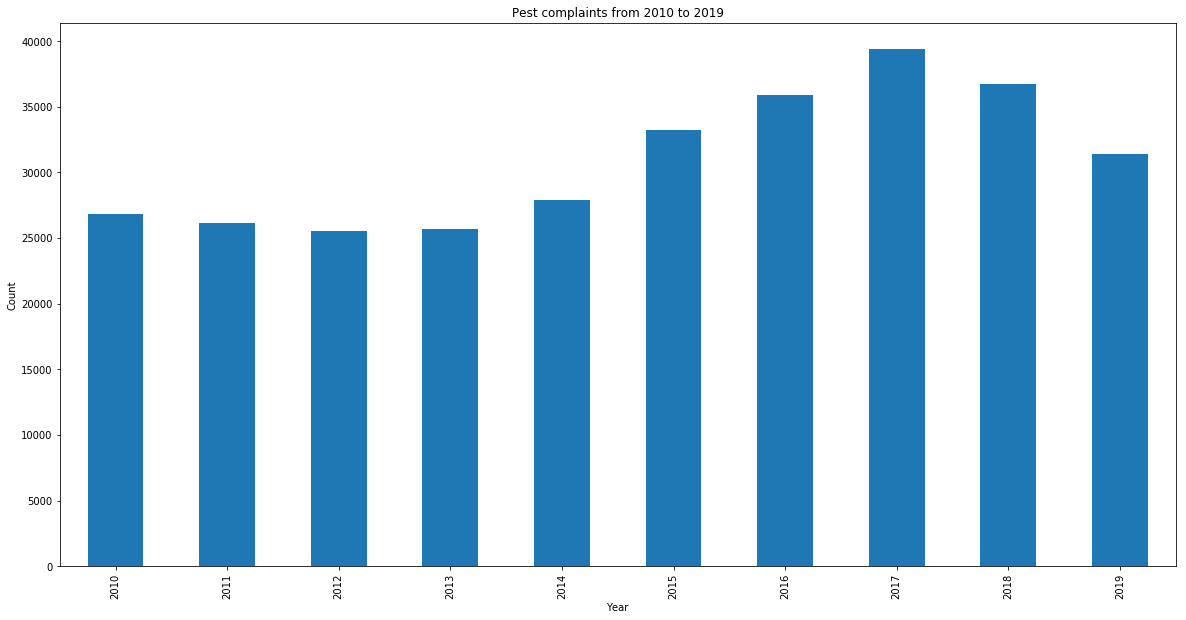

In [8]:
vc = df_pests["Year"].value_counts().sort_index()
ax = vc.plot.bar(figsize=(20,10))
ax.set_title("Pest complaints from 2010 to 2019")
ax.set_xlabel("Year")
ax.set_ylabel("Count")

We observe the general increase in report counts typical of our dataset. Counts increase as reporting technology gets more accessible, and knowledge of 3-1-1 spreads. 2019 count is faulty because of the partial data for this year.

Now, we can take a look at the intra-year or monthly trend.

Text(0, 0.5, 'Count')

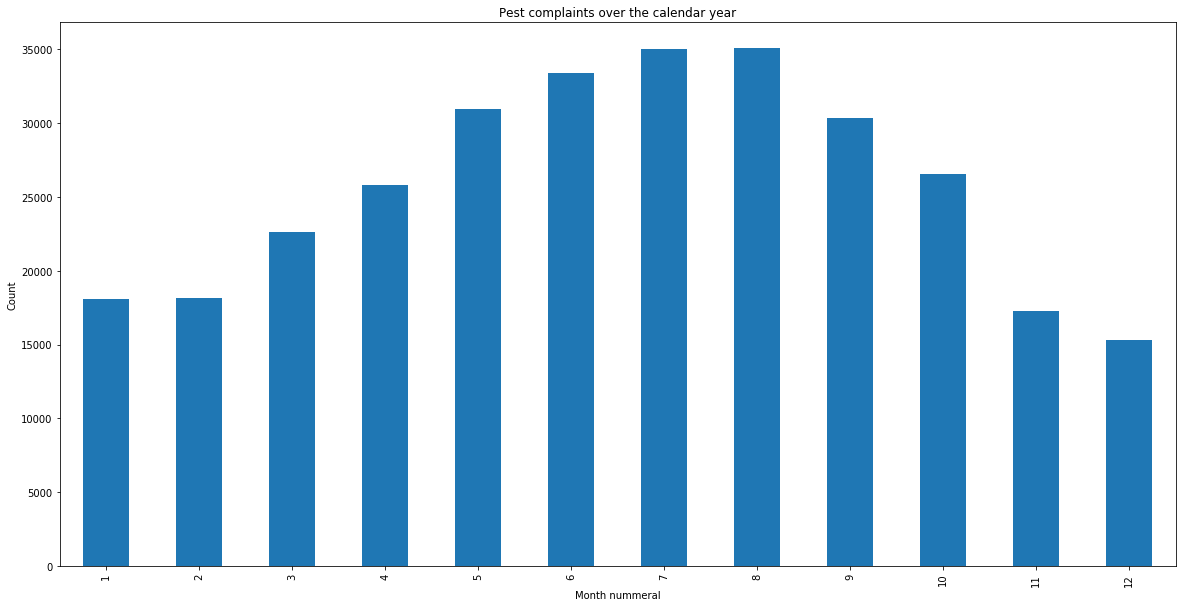

In [9]:
vc = df_pests["Month"].value_counts().sort_index()
ax = vc.plot.bar(figsize=(20,10))
ax.set_title("Pest complaints over the calendar year")
ax.set_xlabel("Month nummeral")
ax.set_ylabel("Count")

We observe an increase in reports during the summer, and a decrease during the winter. This could be entirely explained by the longer time spent outside by humans during summer, increasing sight probability, which is a frequent statistical effect. However, it could be assumed that pests also adventure outside more during the summer, or for longer periods of time, which could contribute to explain the summer peak. 

Looking at intra-month or daily trend was poor in additinal information, it would seem the specific day within the month has no relation on the amount 3-1-1 calls.

Finally, we can look at the intra-day hourly trend.

Text(0, 0.5, 'Count')

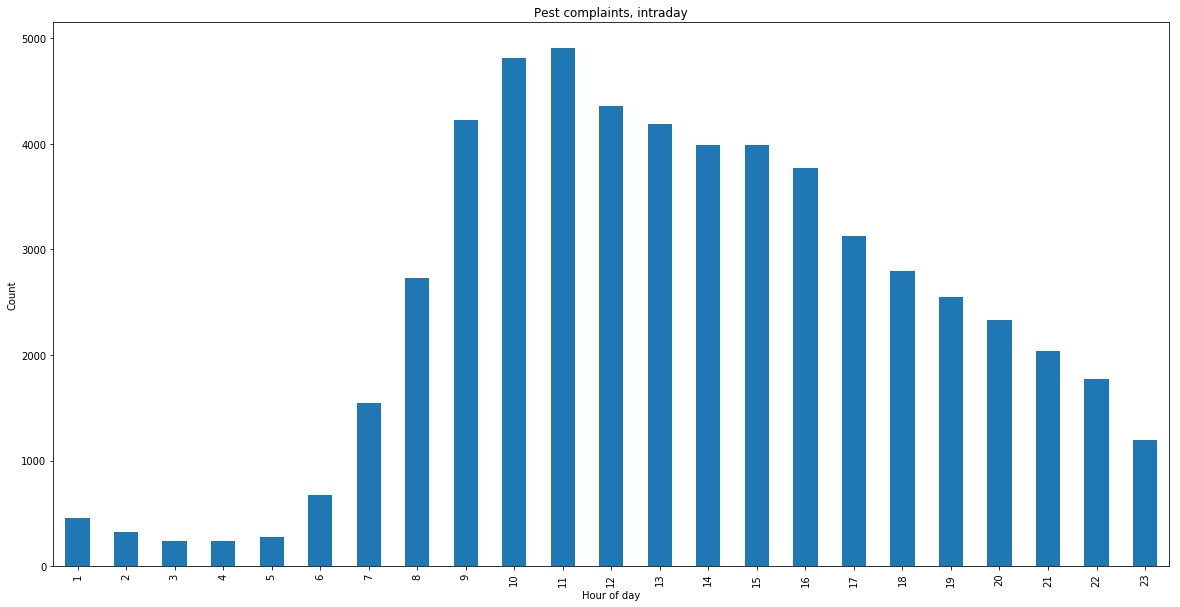

In [10]:

vc = df_pests["Hour"].value_counts().sort_index()
# Remove midnight because many requests logged as hour=0.
vc = vc.iloc[1:]
ax = vc.plot.bar(figsize=(20,10))
ax.set_title("Pest complaints, intraday")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Count")

We observe an increase in reports during the morning, right before lunch. The count correlates with amount of humans that are awoken, but interestingly does not correlate with rush hour, where most new yorkers take the subway, leave their home, and we could imagine would sight most pests.

### _Normalizing counts_

We will now group the data by NTA and by year, and normalize by the explained feature to generate the weight. The weight is a value between 0 and 1, which represent the yearly relative intensity of 3-1-1 calls regarding pests issues. It can be used to generate the heatmap, or to sort NTAs, etc.

In [11]:
nta_pop_df.rename(columns={"NTA Code": "NTA"}, inplace=True)

In [12]:
df_pests_grp = df_pests.groupby(["NTA", "Year"]) \
                                 .count() \
                                 .rename(columns={"Created Date": "Count"})[["Count"]]
df_pests_grp.reset_index(inplace=True)
df_pests_grp.head()

,NTA,Year,Count
0,BK09,2010,44
1,BK09,2011,55
2,BK09,2012,51
3,BK09,2013,29
4,BK09,2014,58


#### First normalization: per capita

As "more people = more calls", we remove this variable's influence from the weight.

In [13]:
df_pests_merge = df_pests_grp.merge(nta_pop_df, on="NTA")
df_pests_merge.drop(columns=["index", "Year_y", "FIPS County Code"], inplace=True)
df_pests_merge.rename(columns={"Year_x": "Year"}, inplace=True)
df_pests_merge["Capita Count"] = df_pests_merge["Count"] / df_pests_merge["Population"]
df_pests_merge["Capita Count"] = df_pests_merge["Capita Count"].replace([np.inf, -np.inf], np.nan)
df_pests_merge = df_pests_merge[~df_pests_merge["Capita Count"].isnull()]

In [14]:
df_pests_merge.sort_values(by="Capita Count", ascending=False).head(10)

,NTA,Year,Count,Borough,NTA Name,Population,Capita Count
509,BK99,2019,58,Brooklyn,park-cemetery-etc-Brooklyn,418,0.138756
507,BK99,2017,51,Brooklyn,park-cemetery-etc-Brooklyn,418,0.122010
1753,QN99,2019,43,Queens,park-cemetery-etc-Queens,436,0.098624
506,BK99,2016,35,Brooklyn,park-cemetery-etc-Brooklyn,418,0.083732
508,BK99,2018,34,Brooklyn,park-cemetery-etc-Brooklyn,418,0.081340
502,BK99,2012,30,Brooklyn,park-cemetery-etc-Brooklyn,418,0.071770
500,BK99,2010,28,Brooklyn,park-cemetery-etc-Brooklyn,418,0.066986
501,BK99,2011,27,Brooklyn,park-cemetery-etc-Brooklyn,418,0.064593
1751,QN99,2017,28,Queens,park-cemetery-etc-Queens,436,0.064220
1750,QN99,2016,23,Queens,park-cemetery-etc-Queens,436,0.052752


In [15]:
df_pests_merge = df_pests_merge[~df_pests_merge["NTA Name"].str.contains("park-cemetery-etc")]
df_pests_merge.sort_values(by="Capita Count", ascending=False).head(10)

,NTA,Year,Count,Borough,NTA Name,Population,Capita Count
307,BK64,2017,576,Brooklyn,Prospect Heights,19849,0.029019
309,BK64,2019,534,Brooklyn,Prospect Heights,19849,0.026903
308,BK64,2018,435,Brooklyn,Prospect Heights,19849,0.021915
583,BX10,2013,552,Bronx,Pelham Bay-Country Club-City Island,26583,0.020765
675,BX30,2015,578,Bronx,Kingsbridge Heights,32496,0.017787
707,BX34,2017,634,Bronx,Melrose South-Mott Haven North,39214,0.016168
306,BK64,2016,314,Brooklyn,Prospect Heights,19849,0.015819
327,BK69,2017,484,Brooklyn,Clinton Hill,34791,0.013912
944,MN11,2019,592,Manhattan,Central Harlem South,43383,0.013646
942,MN11,2017,525,Manhattan,Central Harlem South,43383,0.012102


In [16]:
df_pests_merge.sort_values(by="Capita Count", ascending=True).head(10)

,NTA,Year,Count,Borough,NTA Name,Population,Capita Count
872,BX98,2016,1,Bronx,Rikers Island,11091,0.000090
874,BX98,2019,1,Bronx,Rikers Island,11091,0.000090
873,BX98,2017,1,Bronx,Rikers Island,11091,0.000090
870,BX98,2010,1,Bronx,Rikers Island,11091,0.000090
871,BX98,2015,1,Bronx,Rikers Island,11091,0.000090
471,BK93,2011,2,Brooklyn,Starrett City,13354,0.000150
475,BK93,2015,2,Brooklyn,Starrett City,13354,0.000150
1159,MN50,2014,5,Manhattan,Stuyvesant Town-Cooper Village,21049,0.000238
1158,MN50,2013,5,Manhattan,Stuyvesant Town-Cooper Village,21049,0.000238
476,BK93,2016,4,Brooklyn,Starrett City,13354,0.000300


#### Second normalization: by count of calls per year 

We observe that the number of 311 calls increase over the years. Therefore we normalize with this count to get the changes of NTA importance relative to others instead.

In [17]:
df_pests_2norm = df_pests_merge.merge(df_pests["Year"].value_counts(), on="Year")
get_yc = lambda year: df_pests["Year"].value_counts()[year]
df_pests_merge["Year Count"] = df_pests_merge["Year"].apply(get_yc)
df_pests_merge

,NTA,Year,Count,Borough,NTA Name,Population,Capita Count,Year Count
0,BK09,2010,44,Brooklyn,Brooklyn Heights-Cobble Hill,22887,0.001922,26867
1,BK09,2011,55,Brooklyn,Brooklyn Heights-Cobble Hill,22887,0.002403,26143
2,BK09,2012,51,Brooklyn,Brooklyn Heights-Cobble Hill,22887,0.002228,25522
3,BK09,2013,29,Brooklyn,Brooklyn Heights-Cobble Hill,22887,0.001267,25714
4,BK09,2014,58,Brooklyn,Brooklyn Heights-Cobble Hill,22887,0.002534,27880
...,...,...,...,...,...,...,...,...
1929,SI54,2015,158,Staten Island,Great Kills,40720,0.003880,33202
1930,SI54,2016,205,Staten Island,Great Kills,40720,0.005034,35903
1931,SI54,2017,159,Staten Island,Great Kills,40720,0.003905,39423
1932,SI54,2018,148,Staten Island,Great Kills,40720,0.003635,36699


In [18]:
df_pests_merge["Norm Count"] =  df_pests_merge["Capita Count"] / df_pests_merge["Year Count"]

In [19]:
# Normalize to get max at weight 1. and min at weight 0.
_min, _max = df_pests_merge["Norm Count"].min(), df_pests_merge["Norm Count"].max()
df_pests_merge["Weight"] = (df_pests_merge["Norm Count"] - _min) / (_max - _min)
df_pests_merge

,NTA,Year,Count,Borough,NTA Name,Population,Capita Count,Year Count,Norm Count,Weight
0,BK09,2010,44,Brooklyn,Brooklyn Heights-Cobble Hill,22887,0.001922,26867,7.155577e-08,0.081082
1,BK09,2011,55,Brooklyn,Brooklyn Heights-Cobble Hill,22887,0.002403,26143,9.192177e-08,0.104921
2,BK09,2012,51,Brooklyn,Brooklyn Heights-Cobble Hill,22887,0.002228,25522,8.731053e-08,0.099523
3,BK09,2013,29,Brooklyn,Brooklyn Heights-Cobble Hill,22887,0.001267,25714,4.927646e-08,0.055003
4,BK09,2014,58,Brooklyn,Brooklyn Heights-Cobble Hill,22887,0.002534,27880,9.089633e-08,0.103720
...,...,...,...,...,...,...,...,...,...,...
1929,SI54,2015,158,Staten Island,Great Kills,40720,0.003880,33202,1.168652e-07,0.134118
1930,SI54,2016,205,Staten Island,Great Kills,40720,0.005034,35903,1.402217e-07,0.161458
1931,SI54,2017,159,Staten Island,Great Kills,40720,0.003905,39423,9.904663e-08,0.113261
1932,SI54,2018,148,Staten Island,Great Kills,40720,0.003635,36699,9.903751e-08,0.113250


Let's observe the weight distribution.

# weights in the two last thirds of weight-space: 46


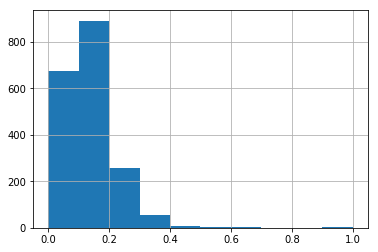

In [20]:
# We will clamp those values to improve the spread of the weights 

df_pests_merge["Weight"].hist()
print("# weights in the two last thirds of weight-space:", df_pests_merge[df_pests_merge["Weight"] > .33].count()["NTA"])


Unfortunaterly, a small number of NTAs offset our weights into a small range. We will clamp those weights to re-center the distribution into a better range for visualization purposes.

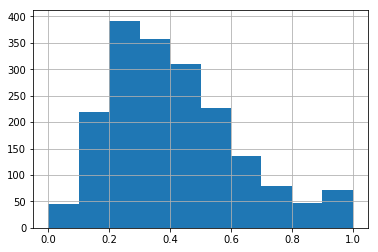

In [21]:

df_pests_merge["Weight"] = df_pests_merge["Weight"].apply(lambda x: .33 if x > .33 else x)
_min, _max = df_pests_merge["Weight"].min(), df_pests_merge["Weight"].max()
df_pests_merge["Weight"] = (df_pests_merge["Weight"] - _min) / (_max - _min)
df_pests_merge["Weight"].hist()

#### Interactive map of our results 

We now generate the timelapse of the change of those weights by NTA. If our normalization is good enough, it should give us an insight into the "true" change of pests sightings intensity of NYC.

In [22]:


def RGB_to_hex(RGB):
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else
            "{0:x}".format(v) for v in RGB])

def get_features(df_source, gj, df_area_key, df_year_key, gj_area_key, relevant_feature):
    df = df_source.copy()
    df.reset_index(inplace=True)
    features = []

    for year in range(2010, 2020):
        for feature in gj["features"]:
            ft = copy.deepcopy(feature)

            area = ft["properties"][gj_area_key]
            df_correct = df[(df[df_area_key] == area) & (df[df_year_key] == year)]

            q = float(df_correct.iloc[0][relevant_feature]\
                if df_correct.shape[0] > 0 else 0)

            color = RGB_to_hex((255*q, 0, 255*(1-q)))

            ft["properties"]["style"] = {
                "fillColor": str(color),
                'weight' : 1,
                'fillOpacity' : 0.66,
                'stroke': False
            }
            ft["properties"]["time"] = str(year)

            features.append(ft)
    return features


def map_features(features):
    m = folium.Map(location=(40.730610, -73.935242), zoom_start=10, tiles="Stamen Toner")

    plugins.TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='P1Y'
        , duration="P1Y"        
        , add_last_point=True
        , auto_play=False
        , loop=False
        , max_speed=0.5
        , loop_button=True
        , date_options='YYYY'
        , time_slider_drag_update=True
    ).add_to(m)

    return m

In [23]:
df_pests_merge.head()

,NTA,Year,Count,Borough,NTA Name,Population,Capita Count,Year Count,Norm Count,Weight
0,BK09,2010,44,Brooklyn,Brooklyn Heights-Cobble Hill,22887,0.001922,26867,7.155577e-08,0.245702
1,BK09,2011,55,Brooklyn,Brooklyn Heights-Cobble Hill,22887,0.002403,26143,9.192177e-08,0.317941
2,BK09,2012,51,Brooklyn,Brooklyn Heights-Cobble Hill,22887,0.002228,25522,8.731053e-08,0.301585
3,BK09,2013,29,Brooklyn,Brooklyn Heights-Cobble Hill,22887,0.001267,25714,4.927646e-08,0.166675
4,BK09,2014,58,Brooklyn,Brooklyn Heights-Cobble Hill,22887,0.002534,27880,9.089633e-08,0.314304


In [24]:
features = get_features(df_pests_merge, geojson, "NTA", "Year", "ntacode", "Weight")


In [25]:

m = map_features(features)
m.save("maps/Pests.html")

Unfortunately, github will not display the interactive map properly in notebook preview form. Consult the github Pages website for the interactive map, or see snapshots for 2011 and 2018 below: 

![2011](images/2011.png)

![2018](images/2019.png)

The following conclusions can be made from the timelapse.

- Clinton Hill, Prospect Heights, Stuyvesant and Bedford, at the center of Brooklyn, have fluctuating intensities over the years but consistently stay at the most pest-affected NTAs of the city.
- During the early years of the decade, Staten Island is impacted more in the southern part. Over the decade, the southern part seems to be left alone by rats gradually, and inversly the nothern part slightly increases in weight. In general the pest intensity slightly subsides over the decade on Staten Island. 
- Southern Queens starts off as a hotspot for pest reporting. It gradually calms over the decade, but stays overall the most affected area in Queens.
- In Central Harlem South, the problem is very intense throughout the decade. Melrose South-Mott Haven North, in the Bronx, witnesses a mostly constant increase in weight over the decade.
- Southern Manhattan appears to gradually become more affected at the first half of the decade which then diminished after 2015.

Here are the areas comparatively unaffected by the problem:
- Southern Brooklyn, especially south of Prospect park.
- North-eastern Queens, east of Flushing-Meadows-Park but above the Grand Central parkway (south of the parkway, Jamaica, is affected).
- South Staten Island since the improvements of the early part of the decade.


Here is our top-10 of pest-spared Neighborhoods using the Weight as a metric

In [26]:
df_pests_merge.drop_duplicates("NTA").sort_values(by="Weight", ascending=True).head(10)["NTA Name"]

870                            Rikers Island
790                              Parkchester
470                            Starrett City
1155          Stuyvesant Town-Cooper Village
1565                             Murray Hill
1325                                Flushing
1465                    Fresh Meadows-Utopia
140                         Sunset Park East
1505    Douglas Manor-Douglaston-Little Neck
1525        Ft. Totten-Bay Terrace-Clearview
Name: NTA Name, dtype: object

And here is our bottom-10 of pest-afflicted Neighborhoods to avoid if you prefer sanitary conditions!

In [27]:
df_pests_merge.drop_duplicates("NTA").sort_values(by="Weight", ascending=False).head(10)["NTA Name"]

390                 Ocean Hill
300           Prospect Heights
150         Stuyvesant Heights
1175             South Jamaica
905           Hamilton Heights
935       Central Harlem South
690                   Longwood
1725              Baisley Park
1904    New Dorp-Midland Beach
320               Clinton Hill
Name: NTA Name, dtype: object